In [169]:
import pandas as pd
from databallpy.visualize import plot_soccer_pitch
from databallpy.features.angle import get_smallest_angle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import joblib


In [170]:
df = pd.read_pickle("positions_goals_dataset.pkl")
df["goal_within_5_events"] = df["n_events_next_goal"].apply(lambda x: True if x <= 5 else False)
df["goal_within_15_seconds"] = df["n_seconds_next_goal"].apply(lambda x: True if x <= 15 else False)
df["goal_within_0_events"] = df["n_events_next_goal"].apply(lambda x: True if x <= 0 else False)
df = df[df["event"]!="own_goal"]
df = df[~((df["event"]=="shot") & (df["successful"]==1) & (df["start_x"] < 0))]

In [177]:
n_x_bins = 64
n_y_bins = 48
x_range = (-53, 53)
y_range = (-34, 34)
width = (x_range[1] - x_range[0]) / n_x_bins
height = (y_range[1] - y_range[0]) / n_y_bins

In [178]:
hist_events, x_edges, y_edges = np.histogram2d(df['start_x'], df['start_y'], bins=(n_x_bins, n_y_bins), range=[x_range, y_range])
hist_shots, _, _ = np.histogram2d(df.loc[df["event"]=="shot", 'start_x'], df.loc[df["event"]=="shot", 'start_y'], bins=(n_x_bins, n_y_bins), range=[x_range, y_range])
hist_goals, _, _ = np.histogram2d(df.loc[((df["event"]=="shot") & (df["successful"]==1)), 'start_x'], df.loc[((df["event"]=="shot") & (df["successful"]==1)), 'start_y'], bins=(n_x_bins, n_y_bins), range=[x_range, y_range]) 
hist_ball_moves, _, _ = np.histogram2d(df.loc[df["event"]!="shot", 'start_x'], df.loc[df["event"]!="shot", 'start_y'], bins=(n_x_bins, n_y_bins), range=[x_range, y_range])
hist_ball_moves_succ, _, _ = np.histogram2d(df.loc[((df["event"]!="shot") & (df["successful"]==1)), 'start_x'], df.loc[((df["event"]!="shot") & (df["successful"]==1)), 'start_y'], bins=(n_x_bins, n_y_bins), range=[x_range, y_range])
ratio_shots = np.divide(hist_shots, hist_events, where=hist_events!=0)
ratio_goals = np.divide(hist_goals, hist_shots, where=hist_shots!=0)
ratio_ball_moves = np.divide(hist_ball_moves, hist_events, where=hist_events!=0)
ratio_ball_moves_succ = np.divide(hist_ball_moves_succ, hist_ball_moves, where=hist_ball_moves!=0)
ratio_failed_actions = 1 - (ratio_ball_moves * ratio_ball_moves_succ) - (ratio_shots * ratio_goals)

In [183]:
def plot_results(data, title=None, label=None):
    fig, ax = plot_soccer_pitch(pitch_color="white")
    pcm = ax.pcolormesh(x_edges, y_edges, data.reshape(n_x_bins, n_y_bins).T * 100, cmap='viridis', alpha=0.9)
    cbar = plt.colorbar(pcm, ax=ax, label=label)
    ax.set_title(title)
    
    for idx in range(len(data)):
        x1 = x_range[0] + (idx // n_y_bins) * width
        y1 = y_range[0] + (idx % n_y_bins) * height
        ax.text(x=x1 + width/2, y=y1+height/2, s=f"{round(data[idx] *100)}", fontsize=4, alpha=0.8, color='black', ha='center', va='center')
    plt.show()

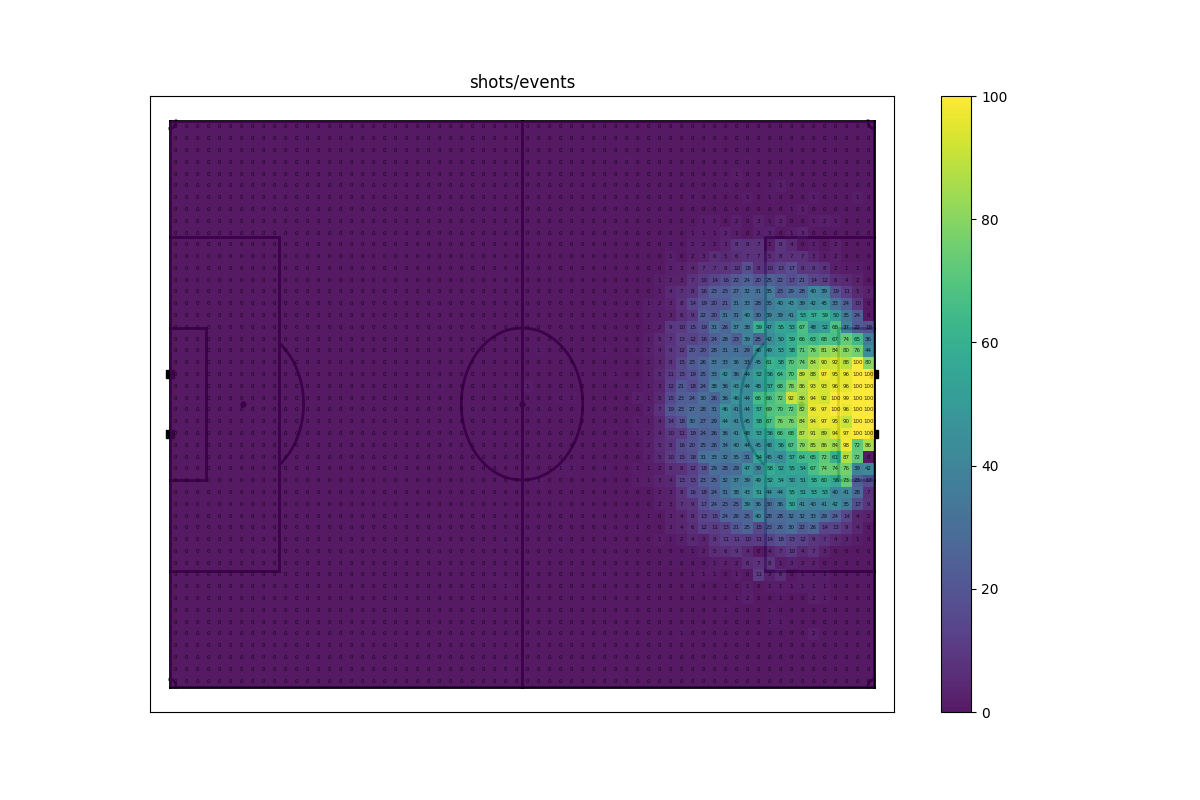

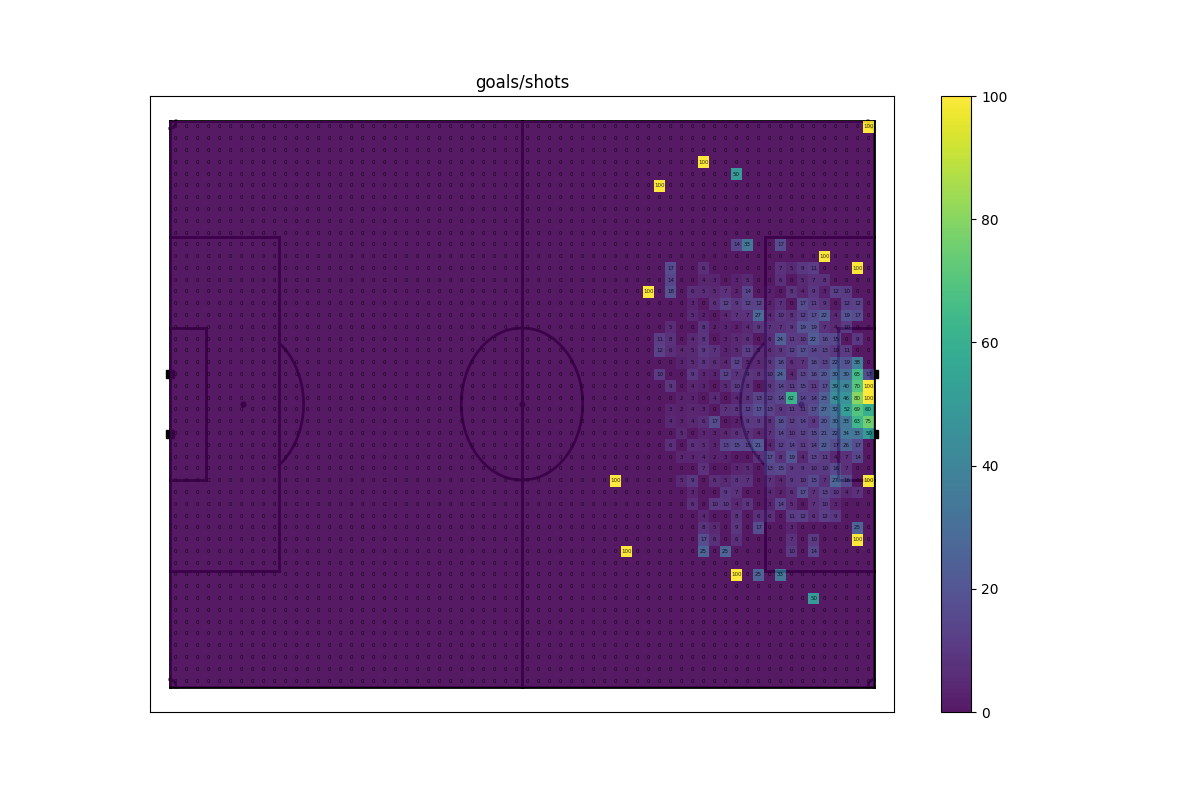

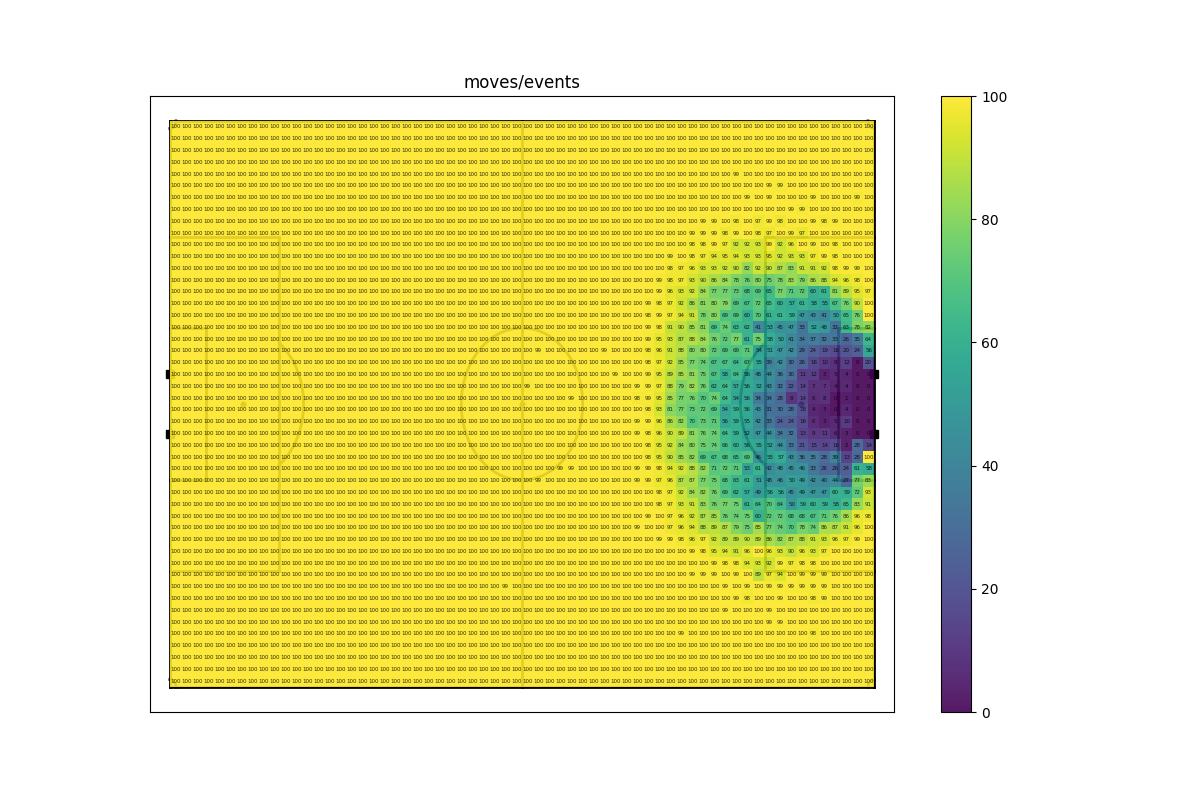

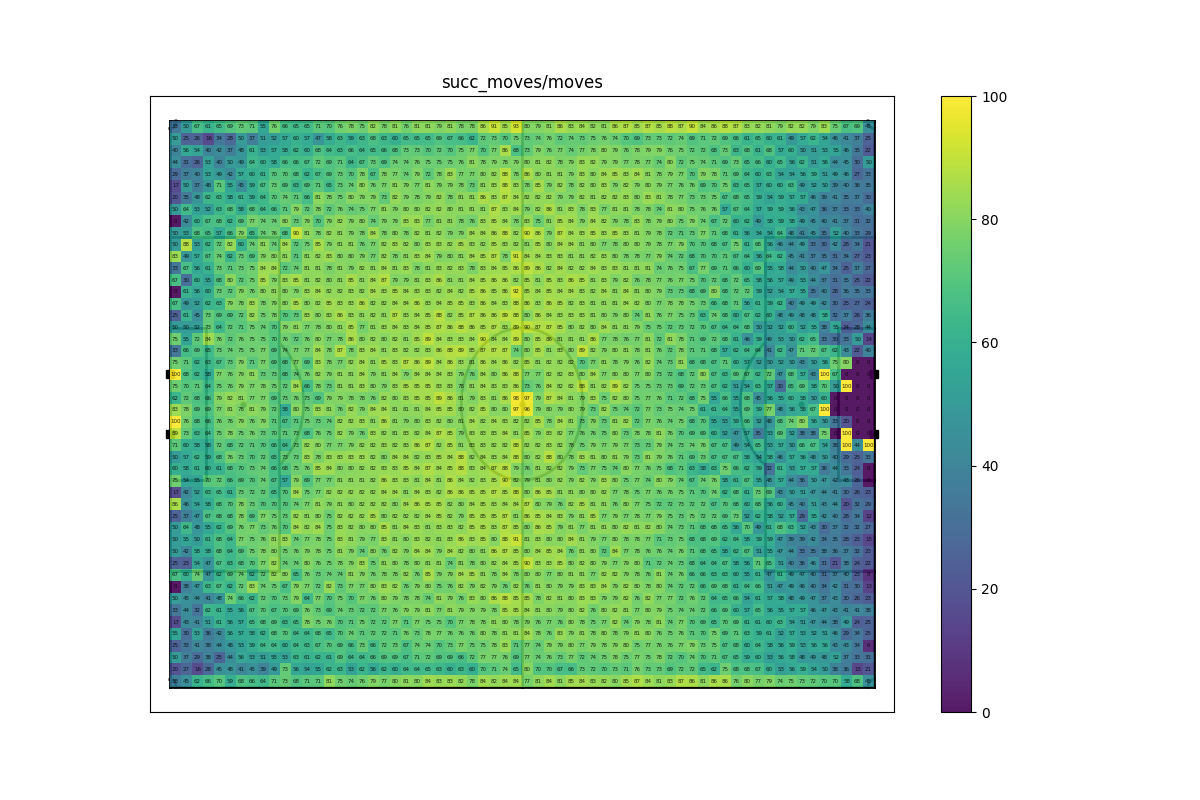

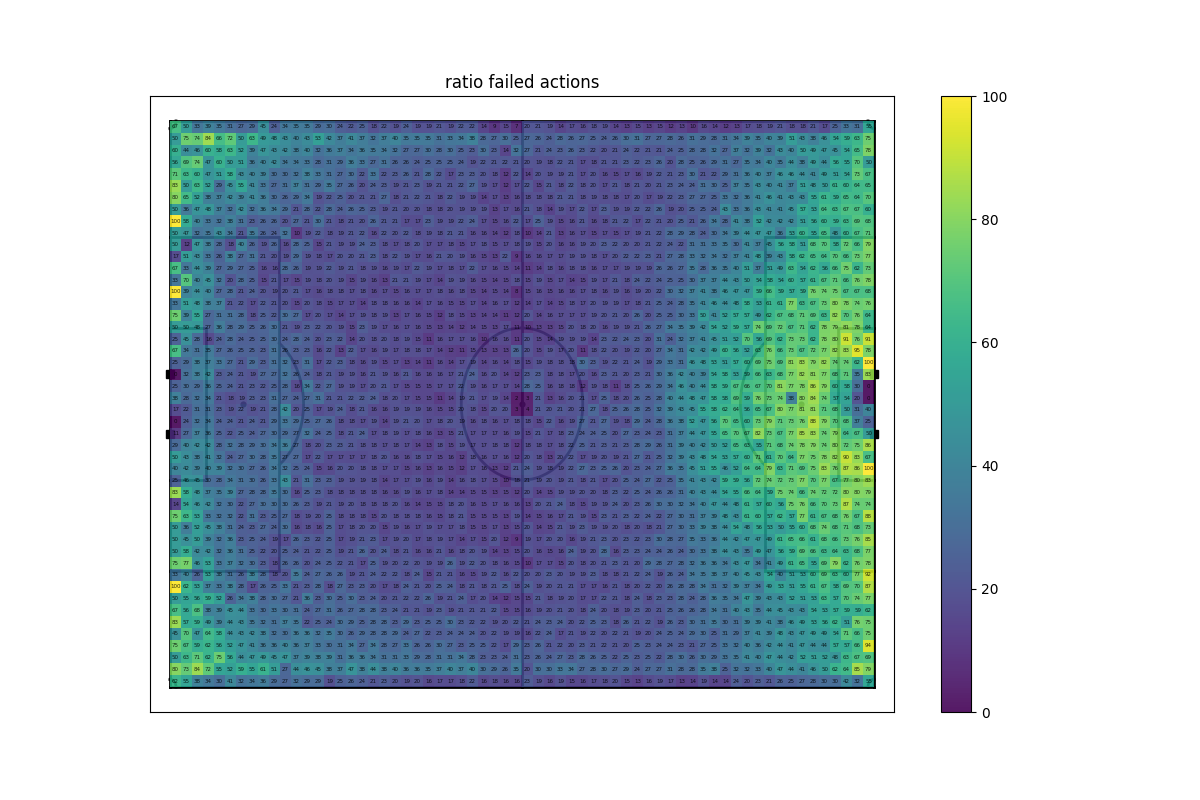

In [184]:
titles = ["shots/events", "goals/shots", "moves/events", "succ_moves/moves", "ratio failed actions"]
ratios = [ratio_shots, ratio_goals, ratio_ball_moves, ratio_ball_moves_succ, ratio_failed_actions]

for title, data in zip(titles, ratios):
    plot_results(data.ravel(), title=title)

In [185]:
succ_move_probs = np.zeros((n_x_bins*n_y_bins, n_x_bins*n_y_bins))
xg_vals = np.zeros(n_x_bins*n_y_bins)

xg_model = joblib.load("../databallpy/models/xG_by_foot_pipeline.pkl")
cell_id = 0
for x_start1, x_start2 in zip(x_edges[:-1], x_edges[1:]):
    start_df_x = df[((df["start_x"] >= x_start1) & (df["start_x"] <= x_start2))]
    for y_start1, y_start2 in zip(y_edges[:-1], y_edges[1:]):
        start_df = start_df_x[((start_df_x["start_y"] >= y_start1) & (start_df_x["start_y"] <= y_start2))]
        succ_mask = (~start_df["end_x"].isnull()) & (~start_df["end_y"].isnull()) & (start_df["event"]!="shot") & (start_df["successful"]==1)
        hist_ball_moves_succ_current_pos, _, _ = np.histogram2d(start_df.loc[succ_mask, "end_x"], start_df.loc[succ_mask, "end_y"], bins=(n_x_bins, n_y_bins), range=[x_range, y_range])
        current_ratio = hist_ball_moves_succ_current_pos / len(start_df)
        succ_move_probs[cell_id] = current_ratio.ravel()

        loc = np.array([np.mean([x_start1, x_start2]), np.mean([y_start1, y_start2])])
        goal_distance = np.sqrt(np.power(x_range[1] - loc[0], 2) + np.power(loc[1], 2))
        shot_angle = get_smallest_angle(loc - np.array([x_range[1], 3.63]), loc - np.array([x_range[1], -3.66]), angle_format="degree")
        xg_vals[cell_id] = xg_model.predict_proba(np.array([[goal_distance, shot_angle]]))[0, 1]

        cell_id += 1        

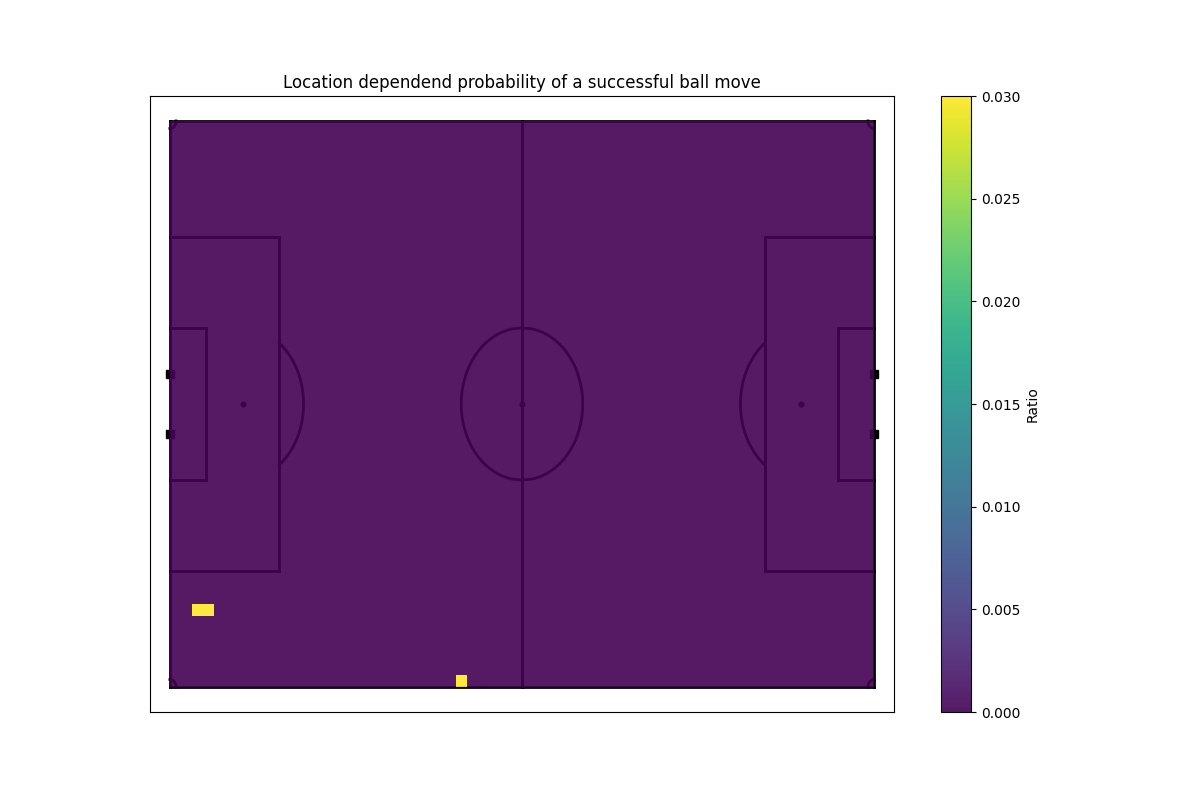

In [187]:
%matplotlib widget

plt.close("all")
fig, ax = plot_soccer_pitch(pitch_color="white")
ratio = succ_move_probs[0].reshape(n_x_bins, n_y_bins)
pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.03)
fig.colorbar(pcm, ax=ax, label="Ratio")
ax.set_title("Location dependend probability of a successful ball move")
width = (x_range[1] - x_range[0]) / n_x_bins
height = (y_range[1] - y_range[0]) / n_y_bins


pitch_size = (x_range[1] - x_range[0], y_range[1] - y_range[0])

def get_mirrored_index(index, n_rows=n_x_bins, n_cols=n_y_bins):
    x_idx = index // n_cols
    x_mean_idx = (n_rows-1) / 2 
    x_diff = np.abs(x_mean_idx - x_idx)
    if x_idx > x_mean_idx:
        x_idx -= (2*x_diff) 
    else:
        x_idx += (2*x_diff) 

    y_idx = index % n_cols
    y_mean_idx = (n_cols-1) / 2 
    y_diff = np.abs(y_mean_idx - y_idx)
    if y_idx > y_mean_idx:
        y_idx -= (2*y_diff) 
    else:
        y_idx += (2*y_diff) 

    return int(x_idx*n_cols + y_idx)
    
    

def on_click(event):
    if event.inaxes == ax:
        x = event.xdata
        y = event.ydata
        x_idx = np.floor((x + x_range[1]) / (pitch_size[0] / n_x_bins))
        y_idx = np.floor((y + y_range[1]) / (pitch_size[1] / n_y_bins))
        idx = int(x_idx * n_y_bins + y_idx)
        ratio = succ_move_probs[idx].reshape(n_x_bins, n_y_bins)

        [col.remove() for col in ax.collections]
        [patch.remove() for patch in ax.patches]
        [text.remove() for text in ax.texts]
        pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.03)
        x1 = x_range[0] + (idx // n_y_bins) * width
        y1 = y_range[0] + (idx % n_y_bins) * height
        rec = Rectangle((x1, y1), width=width, height=height, color='orange', fc='none', lw=2)
        ax.add_patch(rec)

        mirrored_index = get_mirrored_index(idx)
        x2 = x_range[0] + (mirrored_index // n_y_bins) * width
        y2 = y_range[0] + (mirrored_index % n_y_bins) * height
        rec = Rectangle((x2, y2), width=width, height=height, color='red', fc='none', lw=2)
        ax.add_patch(rec)
        ax.scatter([x], [y], color="black")

        ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
        ratio_shot = int(ratio_shots.ravel()[idx] *100)
        xg = round(xg_vals[idx], 2)
        ratio_failed_ball_move = (100 - ratio_suc_ball_move_per - ratio_shot)
        
        ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: {ratio_shot}% (xG={xg}), failed_ball_moves = {ratio_failed_ball_move}%")
                
            

        fig.canvas.draw_idle()
fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

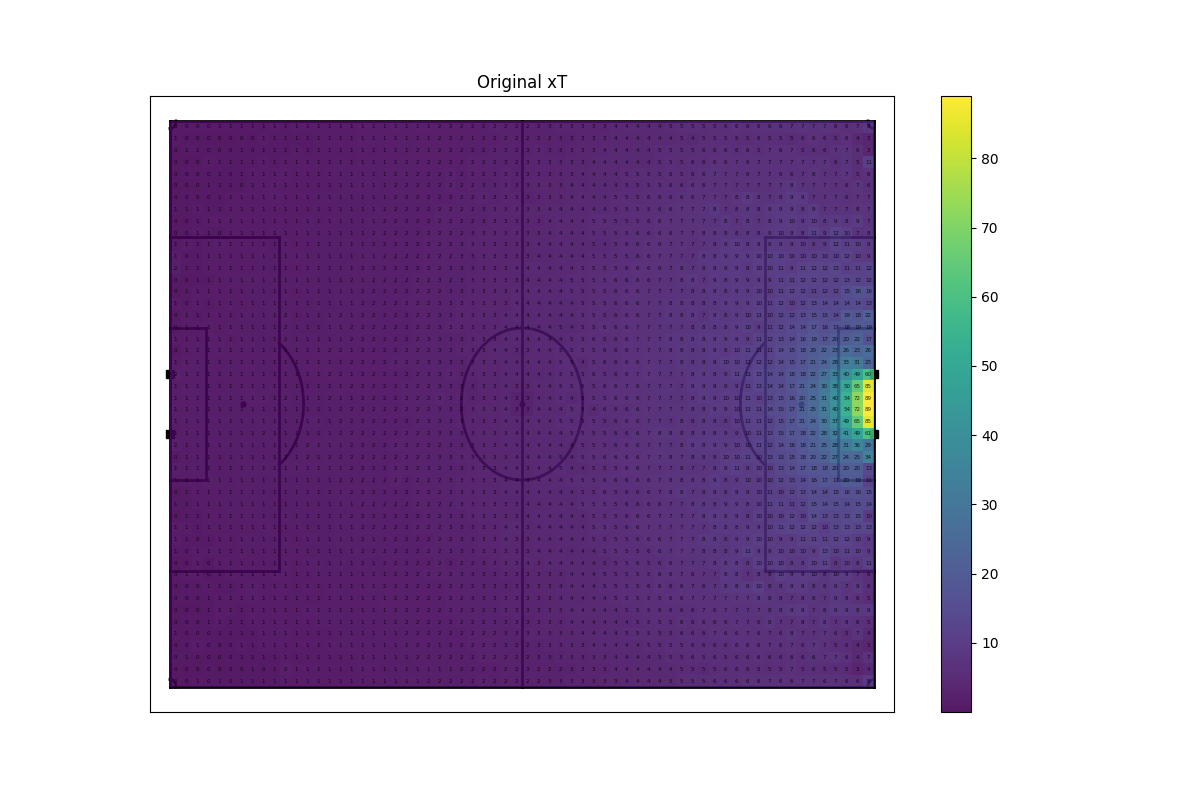

In [188]:
plt.close("all")

original_xT = np.zeros(n_x_bins * n_y_bins)
next_xT = original_xT.copy()
for i in range(7):        
    for current_cell_id in range(len(original_xT)):
        tot_xT = xg_vals[current_cell_id]
        for to_cell_id in range(len(original_xT)):
            tot_xT += succ_move_probs[current_cell_id, to_cell_id] * original_xT[to_cell_id]
        next_xT[current_cell_id] = tot_xT

    original_xT = next_xT

plot_results(original_xT, title="Original xT")

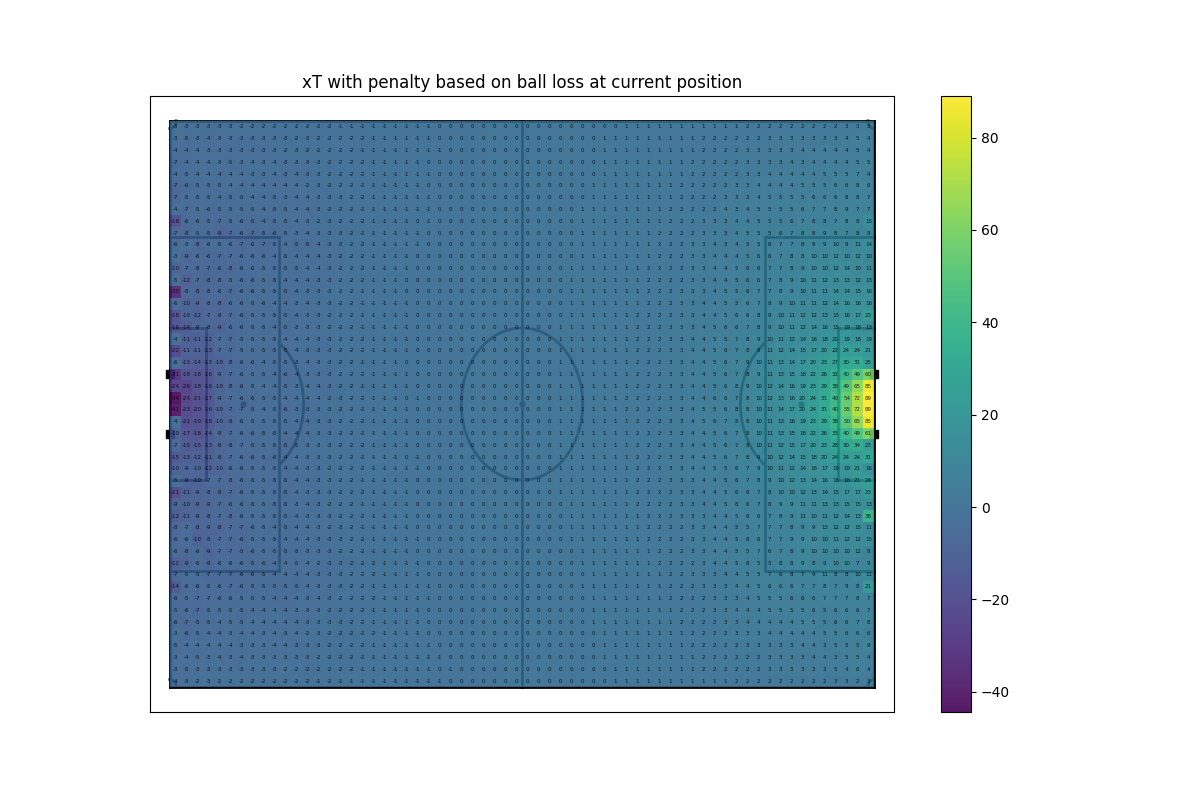

In [189]:
plt.close("all")

xT_position_penalty = np.zeros(n_x_bins * n_y_bins)
next_xT = xT_position_penalty.copy()

for i in range(7):     
    for current_cell_id in range(len(xT_position_penalty)):
        ratio_suc_ball_move = succ_move_probs[current_cell_id].sum()
        ratio_shot = ratio_shots.ravel()[current_cell_id]
        ratio_failed = 1 - ratio_suc_ball_move - ratio_shot

        tot_xT = xg_vals[current_cell_id] - (ratio_failed * xT_position_penalty[get_mirrored_index(current_cell_id)])
        for to_cell_id in range(len(xT)):
            tot_xT += succ_move_probs[current_cell_id, to_cell_id] * xT_position_penalty[to_cell_id]
        next_xT[current_cell_id] = tot_xT

    xT_position_penalty = next_xT

plot_results(xT_position_penalty, title="xT with penalty based on ball loss at current position")

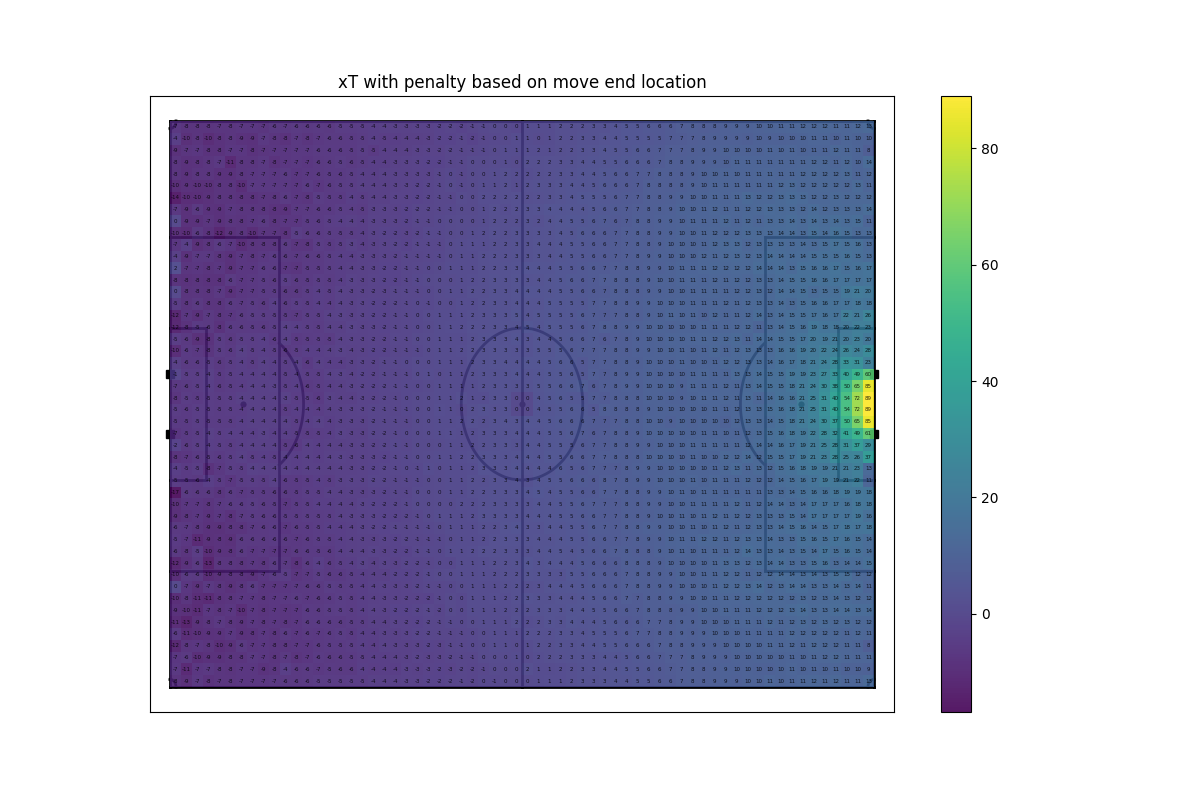

In [190]:
plt.close("all")

xT_next_position_penalty = np.zeros(n_x_bins * n_y_bins)
next_xT = xT_next_position_penalty.copy()

for i in range(7):     
    for current_cell_id in range(len(xT_next_position_penalty)):
        prob_succ_ball_move = succ_move_probs[current_cell_id].sum()
        prob_shot = ratio_shots.ravel()[current_cell_id]
        prob_failed_move = 1 - prob_succ_ball_move - prob_shot
        
        tot_xT = xg_vals[current_cell_id] 
        for to_cell_id in range(len(xT_next_position_penalty)):
            prob_current_ball_move = np.divide(succ_move_probs[current_cell_id, to_cell_id], prob_succ_ball_move, where=prob_succ_ball_move!=0)
            tot_xT += (succ_move_probs[current_cell_id, to_cell_id] * xT_next_position_penalty[to_cell_id])
            tot_xT -= (prob_current_ball_move*prob_failed_move * xT_next_position_penalty[get_mirrored_index(to_cell_id)])
        next_xT[current_cell_id] = tot_xT

    xT_next_position_penalty = next_xT
    
plot_results(xT_next_position_penalty, title="xT with penalty based on move end location")

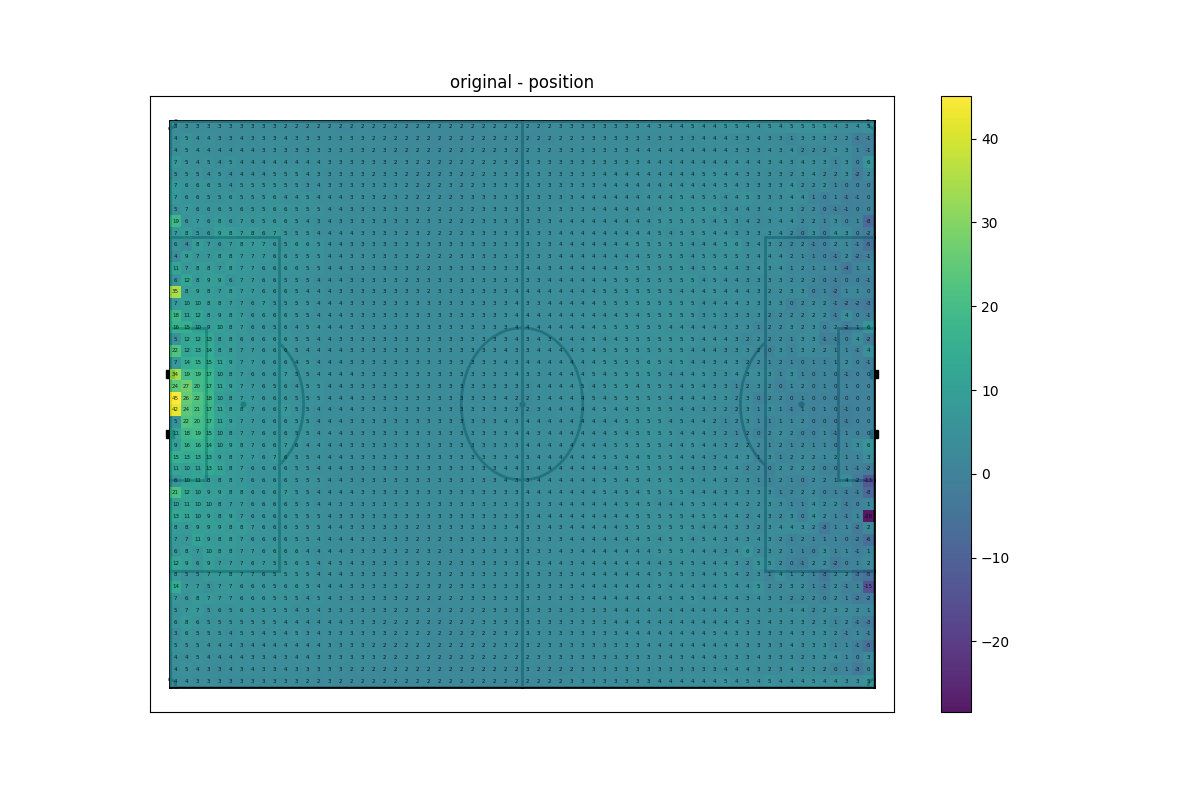

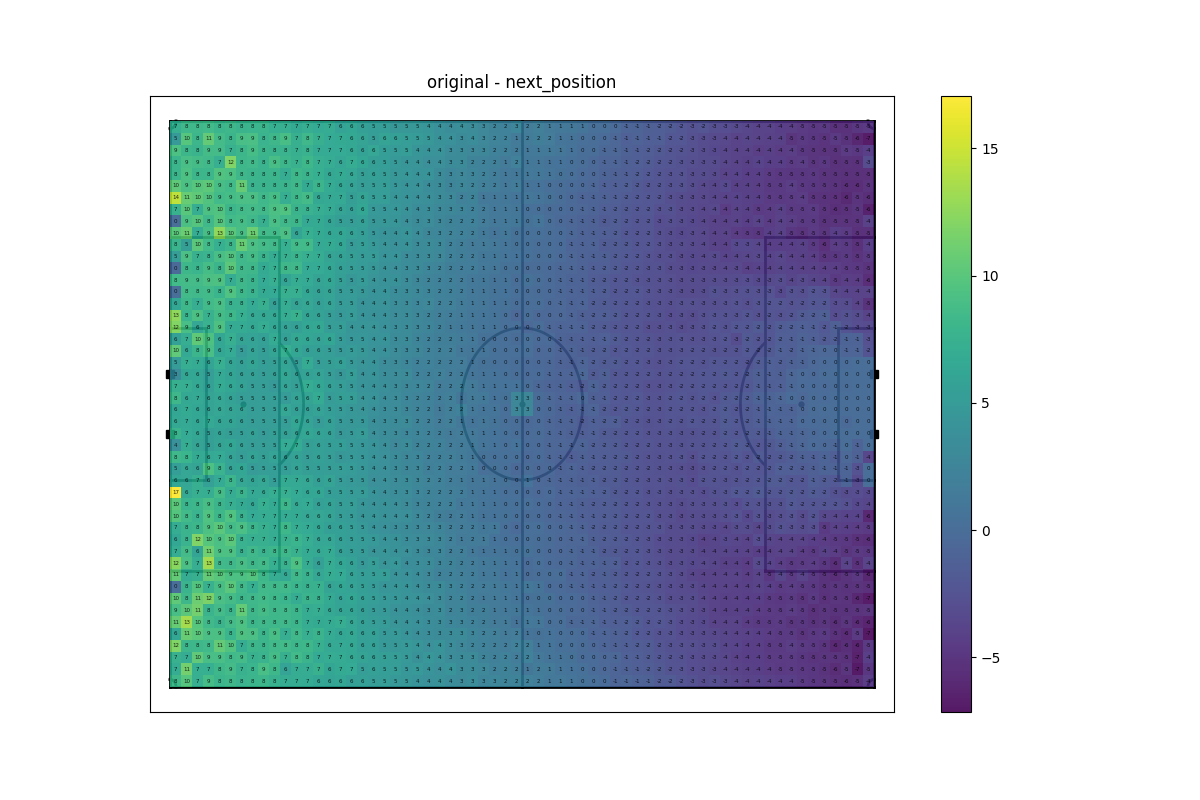

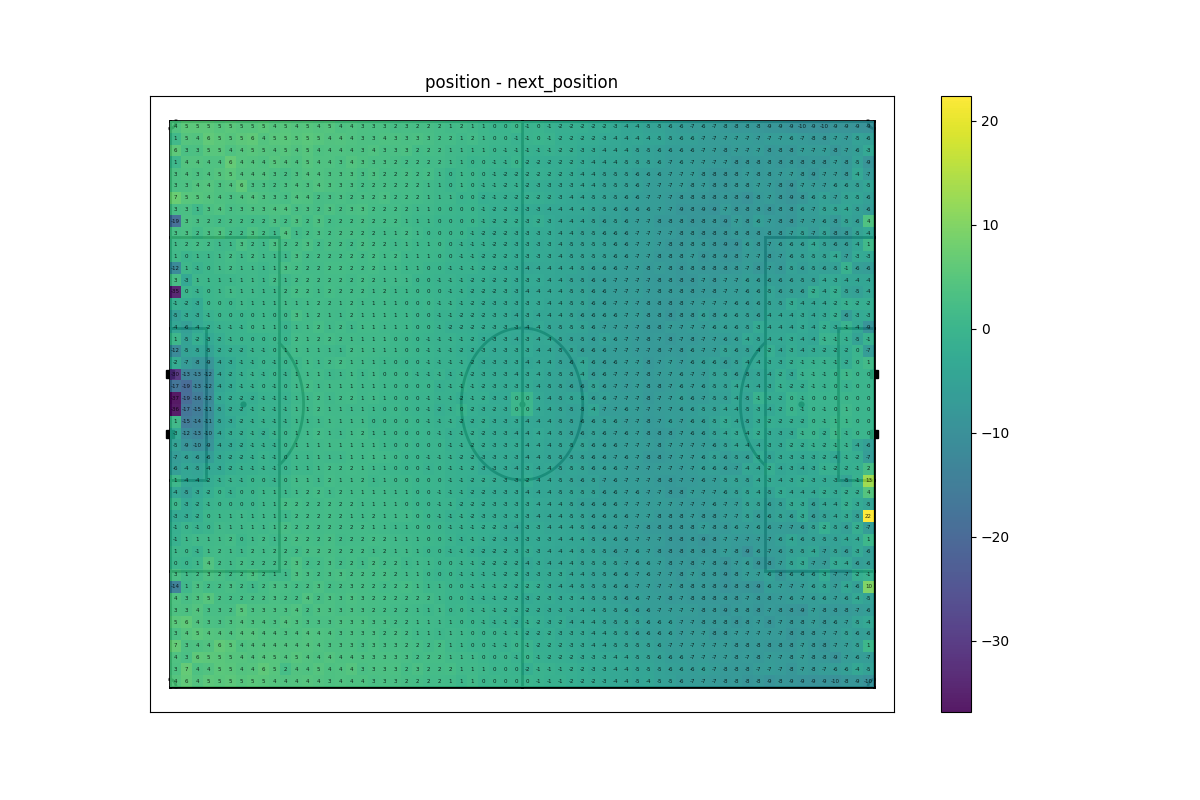

In [191]:
plot_results(original_xT - xT_position_penalty, title="original - position")
plot_results(original_xT - xT_next_position_penalty, title="original - next_position")
plot_results(xT_position_penalty - xT_next_position_penalty, title="position - next_position")